In [15]:
import json
import random
import pandas as pd
import numpy as np
import razdel
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu

### Lead-n

In [16]:
import razdel

def predict_lead(text, n):
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    prediction = " ".join(sentences[:n])
    return prediction

### TextRank¶

In [17]:
# from summa.summarizer import summarize

# def predict_text_rank(text, summary_part=0.1):
#     return summarize(text, ratio=summary_part, language='russian').replace("\n", " ")

In [23]:
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

def text_rank_summarizer(text, number_of_sentences):
    summarizer = TextRankSummarizer()
    parser = PlaintextParser.from_string(
      text,
      Tokenizer("russian"))
    summary = summarizer(parser.document, sentences_count= number_of_sentences)

    summary_text = ''
    for s in summary:
        summary_text = summary_text +' '+ str(s)
  
    return summary_text.strip()

### LexRank

In [19]:
# import lexrank
# from lexrank import LexRank
# from lexrank.mappings.stopwords import STOPWORDS


# def predict_lex_rank(text, lxr, summary_size=1, threshold=None):
#     sentences = [s.text for s in razdel.sentenize(text)]
#     prediction = lxr.get_summary(sentences, summary_size=summary_size, threshold=threshold)
#     prediction = " ".join(prediction)
#     return prediction

In [24]:
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

def predict_lex_rank(text, summary_size):
    summarizer = LexRankSummarizer()
    parser = PlaintextParser.from_string(
      text,
      Tokenizer("russian"))
    summary = summarizer(parser.document, sentences_count= summary_size)

    summary_text = ''
    for s in summary:
        summary_text = summary_text +' '+ str(s)
  
    return summary_text.strip()

### Results and Evaluation

In [25]:
def get_baseline(df, ref_summary_column, text_column, dataset_name, summary_size):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    for index, row in df.iterrows():
        
        text = df[text_column][index]

        sentences = [s.text for s in razdel.sentenize(text)]
#         lxr = LexRank(sentences, stopwords=STOPWORDS['ru'])
        df.at[index, 'lead_1'] = predict_lead(text, 1)
        df.at[index, 'lead_2'] = predict_lead(text, 2)
        df.at[index, 'lead_3'] = predict_lead(text, 3)
        df.at[index, 'text_rank'] = text_rank_summarizer(text, summary_size)
        df.at[index, 'lex_rank'] = predict_lex_rank(text, summary_size)
    
    df.to_csv('../outputs/baselines/baseline_{}_{}.csv'.format(dataset_name, ref_summary_column))

In [32]:
import sys
sys.path.insert(1, '../scripts/')
import pandas as pd
import evaluate
from evaluate import calculate_Bleu_Score, calculate_Rouge_Score, evalute_sample_from_dataset
from plot_eval import plot_rouge, plot_bleu

def evaluate_baseline(df_baseline,ref_summary, dataset_name):
    df_baseline = df_baseline.loc[:, ~df_baseline.columns.str.contains('^Unnamed')]
    metrics = {}
    
    r_l1 = df_baseline[['lead_1',ref_summary]].astype(str)
    r_l2 = df_baseline[['lead_2',ref_summary]].astype(str)
    r_l3 = df_baseline[['lead_3',ref_summary]].astype(str)
    r_text_rank = df_baseline[['text_rank',ref_summary]].astype(str)
    r_lex_rank = df_baseline[['lex_rank',ref_summary]].astype(str)
    
    metrics.update({'LEAD_1':r_l1})
    metrics.update({'LEAD_2':r_l2})
    metrics.update({'LEAD_3':r_l3})
    metrics.update({'TextRank':r_text_rank})
    metrics.update({'LexRank':r_lex_rank})
    print("===========Evaluation of {} Baseline=========".format(dataset_name))
    for name, metric in metrics.items():
        bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores, rougeLsum_scores = evalute_sample_from_dataset(metric, 1000)
        bs = [np.round(i*100, 1) for i in bleu_scores]
        r1 = [np.round(i*100, 1) for i in rouge1_scores]
        r2 = [np.round(i*100, 1) for i in rouge2_scores]
        r_l = [np.round(i*100, 1) for i in rougeL_scores]
        print("============Metric {}===========".format(name))
        print("============BLEU===========", "\n", bs)
        print("============ROUGE-1===========", "\n", r1)
        print("============ROUGE-2===========", "\n", r2)
        print("============ROUGE-L===========", "\n", r_l)
        print("+="*30)

### Gazeta Baseline and Evaluation

In [27]:
gazeta_df = pd.read_json('../dataset/gazeta_2k.json')
gazeta_df = gazeta_df.transpose()

In [ ]:
get_baseline(gazeta_df, 'title', 'text', 'gazeta_2k', summary_size=2)

In [49]:
df_gazeta_baseline = pd.read_csv('../outputs/baselines/baseline_gazeta_2k_title.csv')

In [50]:
evaluate_baseline(df_gazeta_baseline,'title', 'Gazeta_2k')

===========Evaluation of Gazeta_2k Baseline=========
Final Blue Scores [[0.15620611 0.0574101  0.02780555]]
Final ROUGE1 Scores [[0.16146667 0.11753413 0.12831087]]
Final ROUGE2 Scores [[0.04       0.03025    0.03270476]]
Final ROUGEL Scores [[0.15851667 0.11570794 0.12610373]]
Final ROUGELsum Scores [[0.15851667 0.11570794 0.12610373]]
============Metric LEAD_1===========
============BLEU=========== 
 [array([15.6,  5.7,  2.8])]
============ROUGE-1=========== 
 [array([16.1, 11.8, 12.8])]
============ROUGE-2=========== 
 [array([4. , 3. , 3.3])]
============ROUGE-L=========== 
 [array([15.9, 11.6, 12.6])]
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Final Blue Scores [[0.10016782 0.03376855 0.01521371]]
Final ROUGE1 Scores [[0.1833     0.10047222 0.12160499]]
Final ROUGE2 Scores [[0.04633333 0.02488559 0.02971101]]
Final ROUGEL Scores [[0.17851667 0.09738968 0.11805432]]
Final ROUGELsum Scores [[0.17851667 0.09738968 0.11805432]]
============Metric LEAD_2===========
==

### Ria Baseline and Evaluation

In [28]:
ria_df = pd.read_json('../dataset/ria_2k.json')

In [29]:
ria_df = ria_df.transpose() 

In [ ]:
ria_df['text'][1]

In [ ]:
get_baseline(ria_df, 'title', 'text', 'ria_2k', 2)

In [47]:
df_ria_baseline = pd.read_csv('../outputs/baselines/baseline_ria_2k_title.csv')

In [48]:
evaluate_baseline(df_ria_baseline,'title', 'Ria_2k')

===========Evaluation of Ria_2k Baseline=========
Final Blue Scores [[0.0416145  0.018202   0.00836738]]
Final ROUGE1 Scores [[0.19806667 0.03366348 0.05319009]]
Final ROUGE2 Scores [[0.0575     0.00781995 0.01264149]]
Final ROUGEL Scores [[0.19706667 0.03350692 0.05292494]]
Final ROUGELsum Scores [[0.19706667 0.03350692 0.05292494]]
============Metric LEAD_1===========
============BLEU=========== 
 [array([4.2, 1.8, 0.8])]
============ROUGE-1=========== 
 [array([19.8,  3.4,  5.3])]
============ROUGE-2=========== 
 [array([5.8, 0.8, 1.3])]
============ROUGE-L=========== 
 [array([19.7,  3.4,  5.3])]
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Final Blue Scores [[0.03712651 0.01630759 0.00741024]]
Final ROUGE1 Scores [[0.20106667 0.02982534 0.04855359]]
Final ROUGE2 Scores [[0.0575     0.00734231 0.01189222]]
Final ROUGEL Scores [[0.20006667 0.02966878 0.04828844]]
Final ROUGELsum Scores [[0.20006667 0.02966878 0.04828844]]
============Metric LEAD_2===========
========

### Baseline and Evaluation of RBC

In [ ]:
rbc_df = pd.read_json('../dataset/rbc_2k.json')
rbc_df = rbc_df.transpose()

In [ ]:
get_baseline(rbc_df, 'headline', 'article_text', 'rbc_2k', summary_size=2)

In [45]:
df_rbc_baseline = pd.read_csv('../outputs/baselines/baseline_rbc_2k_headline.csv')

In [46]:
evaluate_baseline(df_rbc_baseline,'headline', 'rbc_2k')

===========Evaluation of rbc_2k Baseline=========
Final Blue Scores [[0.16600338 0.08235237 0.05355827]]
Final ROUGE1 Scores [[0.19758333 0.1162462  0.13386875]]
Final ROUGE2 Scores [[0.05933333 0.03217736 0.03738529]]
Final ROUGEL Scores [[0.196      0.11518668 0.13266875]]
Final ROUGELsum Scores [[0.196      0.11518668 0.13266875]]
============Metric LEAD_1===========
============BLEU=========== 
 [array([16.6,  8.2,  5.4])]
============ROUGE-1=========== 
 [array([19.8, 11.6, 13.4])]
============ROUGE-2=========== 
 [array([5.9, 3.2, 3.7])]
============ROUGE-L=========== 
 [array([19.6, 11.5, 13.3])]
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Final Blue Scores [[0.10463102 0.05048232 0.03056951]]
Final ROUGE1 Scores [[0.28408333 0.09392873 0.12650014]]
Final ROUGE2 Scores [[0.077      0.01931316 0.02834125]]
Final ROUGEL Scores [[0.28241667 0.09307635 0.12546681]]
Final ROUGELsum Scores [[0.28241667 0.09307635 0.12546681]]
============Metric LEAD_2===========
=====

## Overview Baseline (RBC-Gazeta)

In [ ]:
rbc_df = pd.read_json('../dataset/rbc_2k.json')
rbc_df = rbc_df.transpose()

In [ ]:
get_baseline(rbc_df, 'article_overview', 'article_text', 'rbc_2k', summary_size=5)

In [42]:
df_rbc_baseline = pd.read_csv('../outputs/baselines/baseline_rbc_2k_article_overview.csv')
evaluate_baseline(df_rbc_baseline,'article_overview', 'rbc_2k')

===========Evaluation of rbc_2k Baseline=========
Final Blue Scores [[0.4486657  0.43124947 0.42226113]]
Final ROUGE1 Scores [[0.36510476 0.34084814 0.32671802]]
Final ROUGE2 Scores [[0.19112381 0.16974567 0.16230519]]
Final ROUGEL Scores [[0.3636881  0.33956481 0.32546009]]
Final ROUGELsum Scores [[0.3636881  0.33956481 0.32546009]]
============Metric LEAD_1===========
============BLEU=========== 
 [array([44.9, 43.1, 42.2])]
============ROUGE-1=========== 
 [array([36.5, 34.1, 32.7])]
============ROUGE-2=========== 
 [array([19.1, 17. , 16.2])]
============ROUGE-L=========== 
 [array([36.4, 34. , 32.5])]
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Final Blue Scores [[0.47858102 0.46880072 0.45971239]]
Final ROUGE1 Scores [[0.52762619 0.28895309 0.34019952]]
Final ROUGE2 Scores [[0.30164762 0.13378083 0.16593082]]
Final ROUGEL Scores [[0.52654286 0.28795309 0.33924714]]
Final ROUGELsum Scores [[0.52654286 0.28795309 0.33924714]]
============Metric LEAD_2===========
==

In [ ]:
gazeta_df = pd.read_json('../dataset/gazeta_2k.json')
gazeta_df = gazeta_df.transpose()
get_baseline(gazeta_df, 'summary', 'text', 'gazeta_2k', summary_size=2)

In [30]:
df_gazeta_baseline = pd.read_csv('../outputs/baselines/baseline_gazeta_2k_summary.csv')
evaluate_baseline(df_gazeta_baseline,'summary', 'Gazeta_2k')

===========Evaluation of Gazeta_2k Baseline=========


/home/aliak/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Final Blue Scores [[0.12818366 0.06426406 0.03978222]]
Final ROUGE1 Scores [[0.21653294 0.24501667 0.21477646]]
Final ROUGE2 Scores [[0.07510094 0.0838     0.07504437]]
Final ROUGEL Scores [[0.21240754 0.24009286 0.21050592]]
Final ROUGELsum Scores [[0.21240754 0.24009286 0.21050592]]
============Metric LEAD_1===========
============BLEU=========== 
 [array([12.8,  6.4,  4. ])]
============ROUGE-1=========== 
 [array([21.7, 24.5, 21.5])]
============ROUGE-2=========== 
 [array([7.5, 8.4, 7.5])]
============ROUGE-L=========== 
 [array([21.2, 24. , 21.1])]
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Final Blue Scores [[0.22317821 0.09981068 0.05870949]]
Final ROUGE1 Scores [[0.2803631  0.24488294 0.24204304]]
Final ROUGE2 Scores [[0.09801483 0.08471886 0.0839831 ]]
Final ROUGEL Scores [[0.27262103 0.23784921 0.23502337]]
Final ROUGELsum Scores [[0.27262103 0.23784921 0.23502337]]
============Metric LEAD_2===========
============BLEU=========== 
 [array([22.3, 10. ,  5.9]

In [37]:
from evaluate import present_metric_results, calculate_Bleu_Score, calculate_Rouge_Score, evalute_sample_from_dataset
from plot_eval import plot_rouge, plot_bleu

In [38]:
def present_metric_results(datafile_csv):
    summary_datafile = datafile_csv
    
    bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores, rougeLsum_scores = evalute_sample_from_dataset(summary_datafile, 300)

    rouge_eval = []
    rouge_eval.append(rouge1_scores[0].tolist())
    rouge_eval.append(rouge2_scores[0].tolist())
    rouge_eval.append(rougeL_scores[0].tolist())
    rouge_eval.append(rougeLsum_scores[0].tolist())

    rouge_eval = (np.array(rouge_eval))
    print("="*20, datafile_csv)
    plot_rouge(rouge_eval)
    plot_bleu(bleu_scores)

Final Blue Scores [[0.10349982 0.04355696 0.02271612]]
Final ROUGE1 Scores [[0.21583333 0.12595527 0.14422511]]
Final ROUGE2 Scores [[0.04722222 0.03019444 0.03347619]]
Final ROUGEL Scores [[0.21138889 0.12454323 0.14218807]]
Final ROUGELsum Scores [[0.21138889 0.12454323 0.14218807]]
==================== ../outputs/mbart/summaries_mbart_headline_article_text_rbc_2k.csv


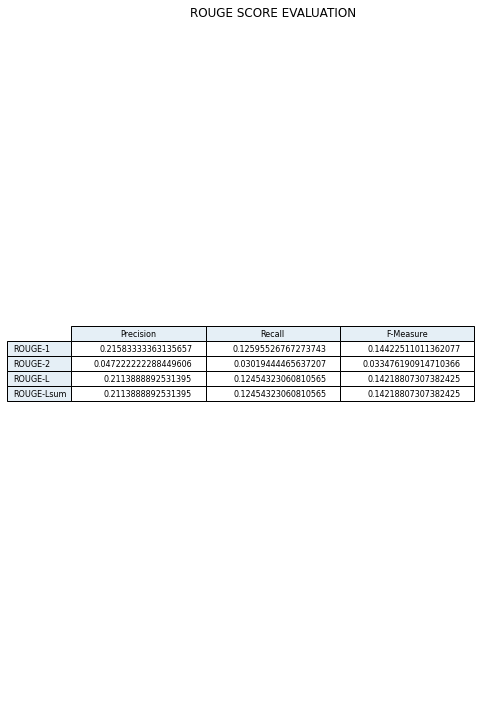

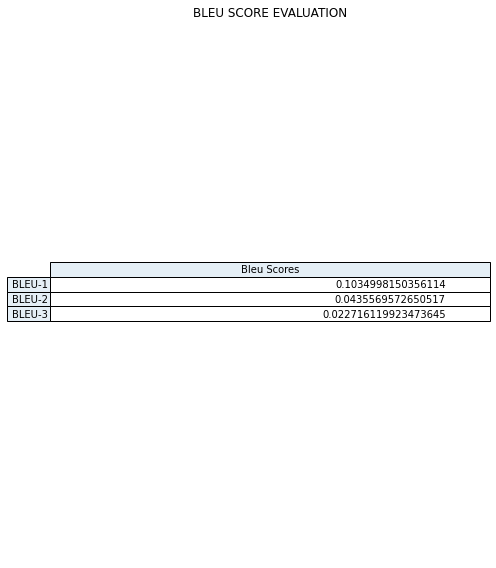

Final Blue Scores [[0.08146605 0.02903613 0.01312992]]
Final ROUGE1 Scores [[0.15666667 0.11252646 0.12082059]]
Final ROUGE2 Scores [[0.04166667 0.02703968 0.02950794]]
Final ROUGEL Scores [[0.15416667 0.11163757 0.11959837]]
Final ROUGELsum Scores [[0.15416667 0.11163757 0.11959837]]
==================== ../outputs/mbart/summaries_mbart_title_text_gazeta_2k.csv


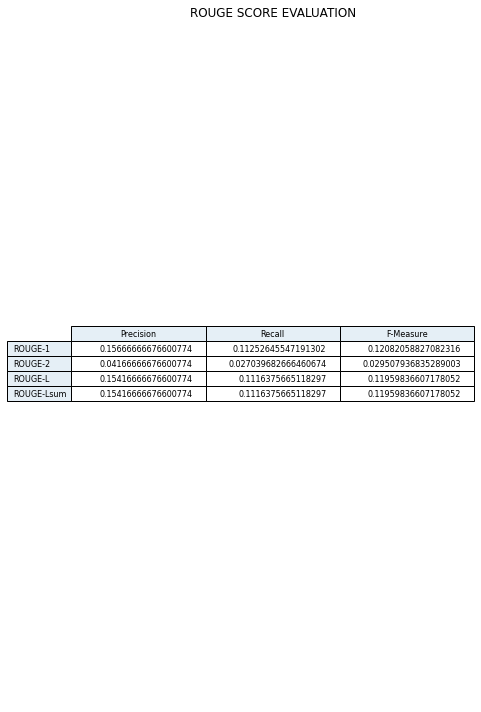

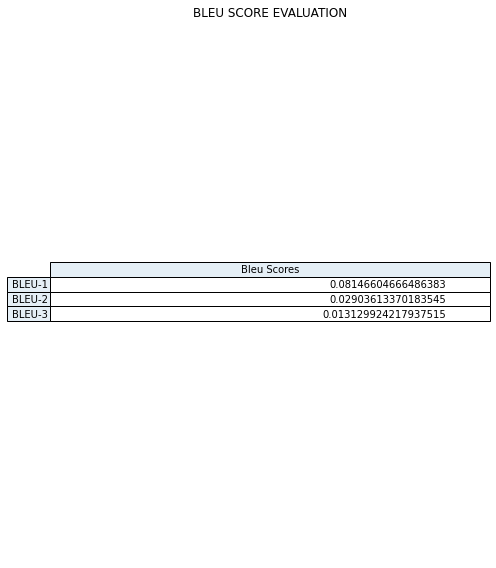

Final Blue Scores [[0.26657697 0.11734461 0.06852757]]
Final ROUGE1 Scores [[0.30101058 0.2633664  0.26117145]]
Final ROUGE2 Scores [[0.11578704 0.09084536 0.09481116]]
Final ROUGEL Scores [[0.2965291  0.25894048 0.25678594]]
Final ROUGELsum Scores [[0.2965291  0.25894048 0.25678594]]
==================== ../outputs/mbart/summaries_mbart_summary_text_gazeta_2k.csv


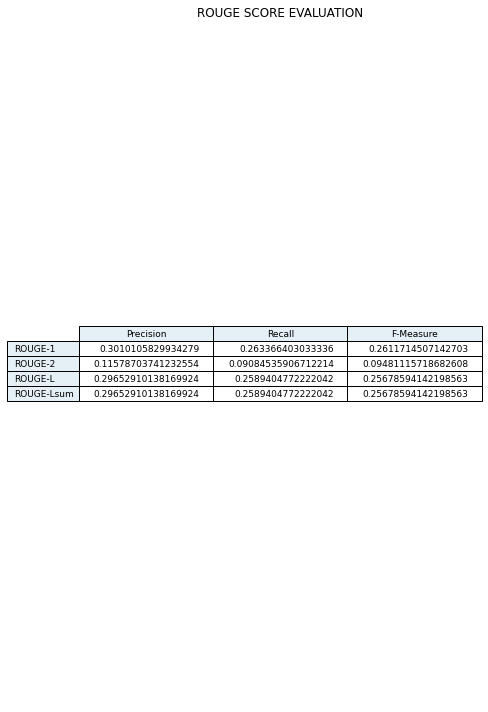

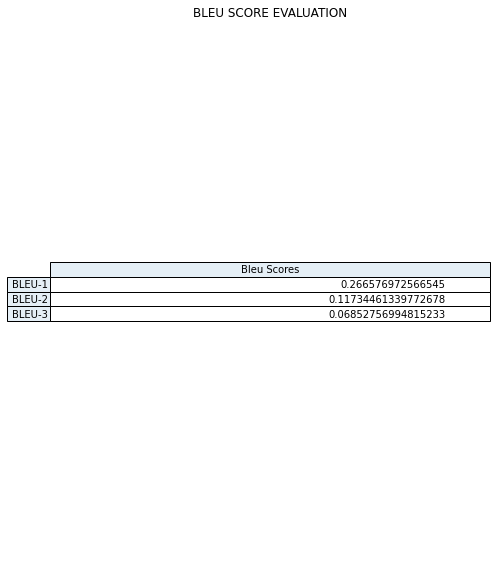

Final Blue Scores [[0.11648475 0.03956925 0.01504525]]
Final ROUGE1 Scores [[0.15527778 0.09658249 0.11269048]]
Final ROUGE2 Scores [[0.05222222 0.02888889 0.03368132]]
Final ROUGEL Scores [[0.15527778 0.09658249 0.11269048]]
Final ROUGELsum Scores [[0.15527778 0.09658249 0.11269048]]
==================== ../outputs/mbart/summaries_mbart_title_text_ria_2k.csv


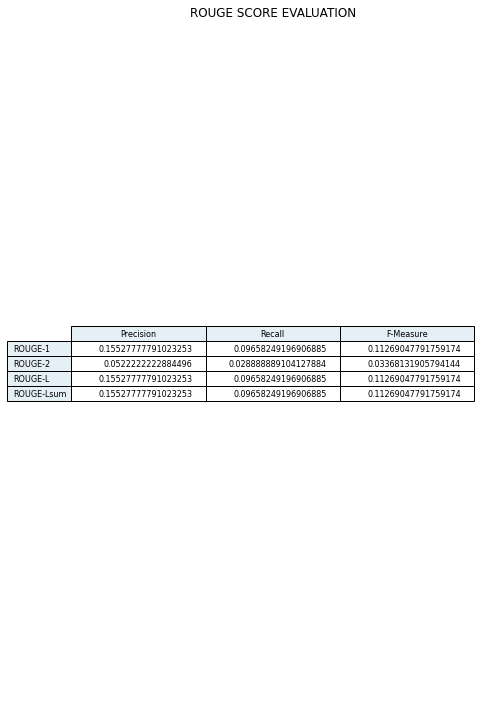

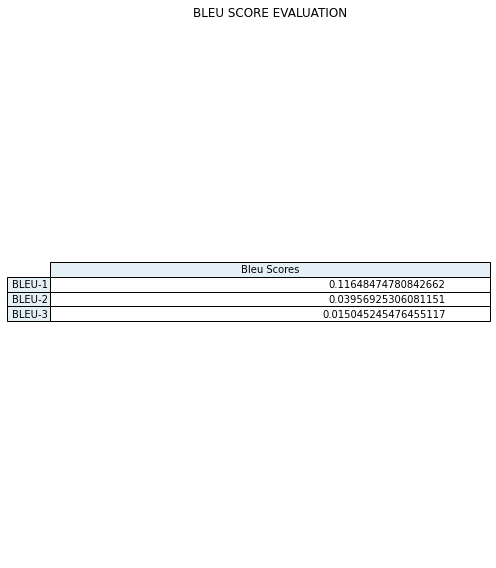

Final Blue Scores [[0.39373606 0.30133937 0.25461566]]
Final ROUGE1 Scores [[0.37413889 0.30978584 0.31759225]]
Final ROUGE2 Scores [[0.15122222 0.1067476  0.11502407]]
Final ROUGEL Scores [[0.36374206 0.30169457 0.30894543]]
Final ROUGELsum Scores [[0.36374206 0.30169457 0.30894543]]
==================== ../outputs/mbart/summaries_mbart_article_overview_article_text_rbc_2k.csv


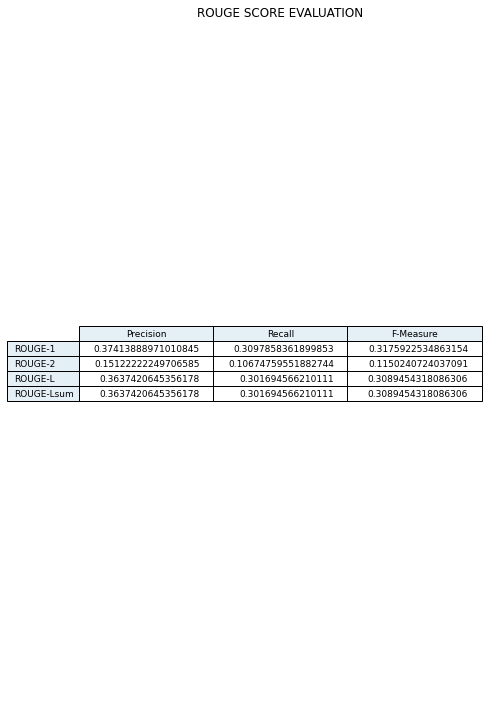

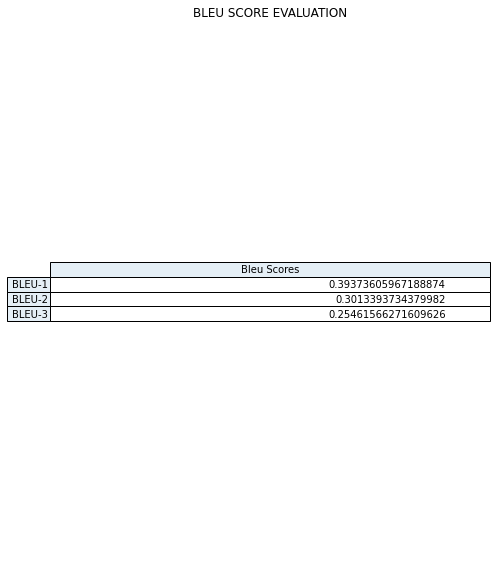

In [39]:
mbart_folder = '../outputs/mbart/'
from os import walk

f = []
for (dirpath, dirnames, csv_datafiles) in walk(mbart_folder):
    for csv_file in csv_datafiles:
        present_metric_results("../outputs/mbart/{}".format(csv_file))

Final Blue Scores [[0.88513635 0.88264996 0.88106523]]
Final ROUGE1 Scores [[0.49656349 0.5175     0.49981602]]
Final ROUGE2 Scores [[0.26544444 0.26833333 0.26504233]]
Final ROUGEL Scores [[0.49656349 0.5175     0.49981602]]
Final ROUGELsum Scores [[0.49656349 0.5175     0.49981602]]
==================== ../outputs/t5/summaries_t5_article_overview_article_text_rbc_dataset (1).csv


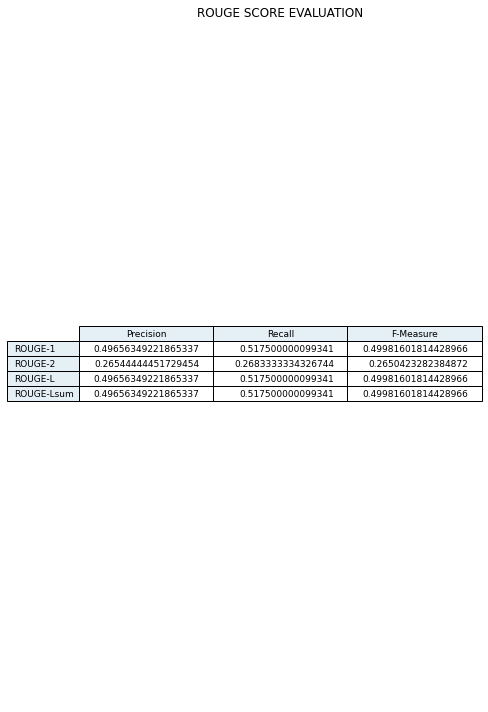

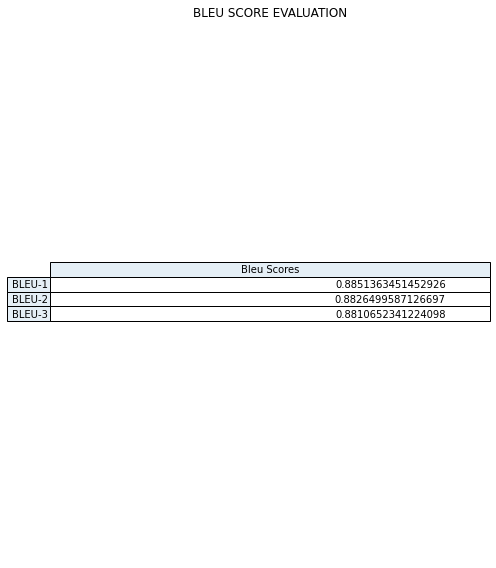

Final Blue Scores [[0.33738554 0.19310625 0.12592379]]
Final ROUGE1 Scores [[0.13833333 0.13633333 0.13512698]]
Final ROUGE2 Scores [[0.025      0.02416667 0.02355556]]
Final ROUGEL Scores [[0.13833333 0.13633333 0.13512698]]
Final ROUGELsum Scores [[0.13833333 0.13633333 0.13512698]]
==================== ../outputs/t5/summaries_t5_title_text_ria_2k.csv


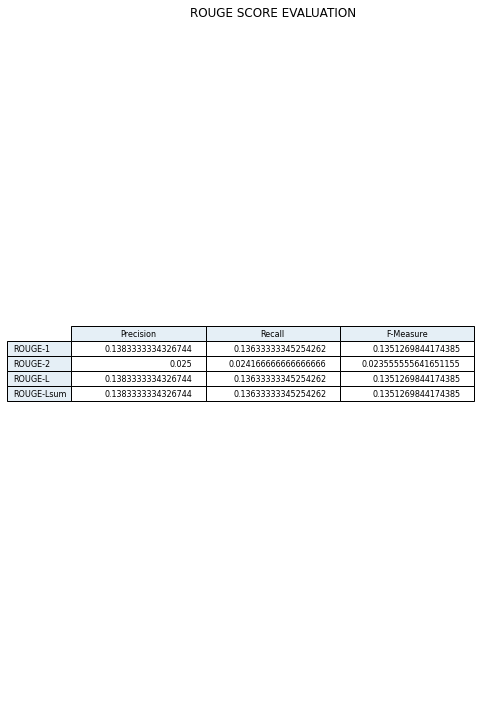

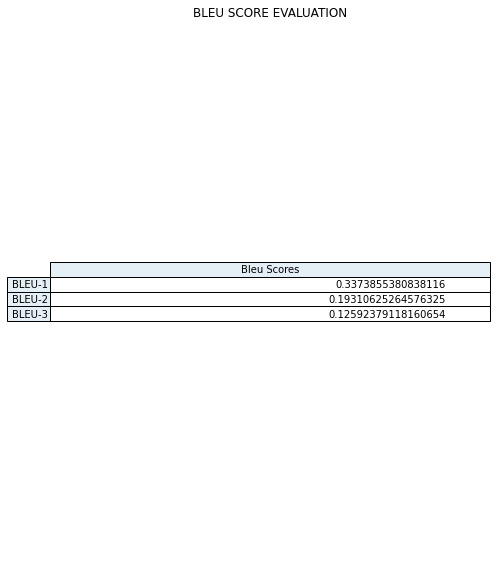

Final Blue Scores [[0.38341606 0.25469928 0.1909421 ]]
Final ROUGE1 Scores [[0.15444444 0.15444444 0.15      ]]
Final ROUGE2 Scores [[0.02833333 0.02611111 0.02611111]]
Final ROUGEL Scores [[0.15277778 0.15277778 0.14833333]]
Final ROUGELsum Scores [[0.15277778 0.15277778 0.14833333]]
==================== ../outputs/t5/summaries_t5_headline_article_text_rbc_dataset.csv


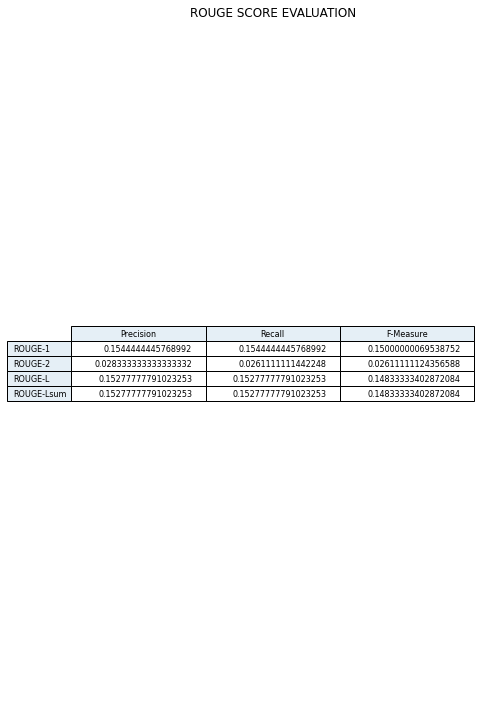

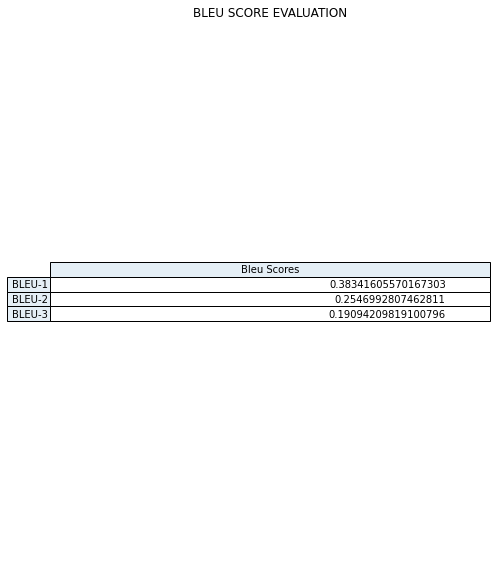

Final Blue Scores [[0.26484451 0.13006448 0.07216753]]
Final ROUGE1 Scores [[0.10133333 0.10666667 0.10171429]]
Final ROUGE2 Scores [[0.03361111 0.03888889 0.03455556]]
Final ROUGEL Scores [[0.10133333 0.10666667 0.10171429]]
Final ROUGELsum Scores [[0.10133333 0.10666667 0.10171429]]
==================== ../outputs/t5/summaries_t5_title_text_gazeta_2k.csv


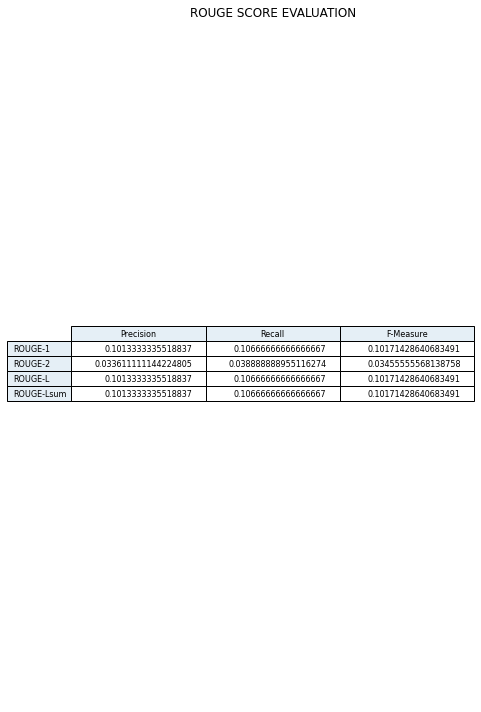

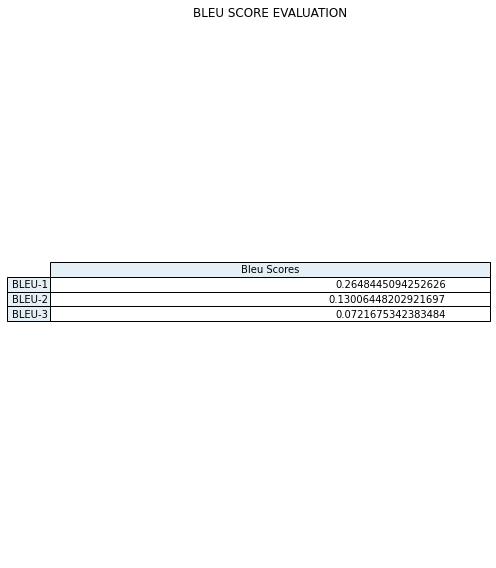

Final Blue Scores [[0.16552507 0.06256626 0.03248682]]
Final ROUGE1 Scores [[0.17279365 0.19058333 0.16727512]]
Final ROUGE2 Scores [[0.05936508 0.05492064 0.05410847]]
Final ROUGEL Scores [[0.16937698 0.18697222 0.16384077]]
Final ROUGELsum Scores [[0.16937698 0.18697222 0.16384077]]
==================== ../outputs/t5/summaries_t5_summary_text_gazeta_2k.csv


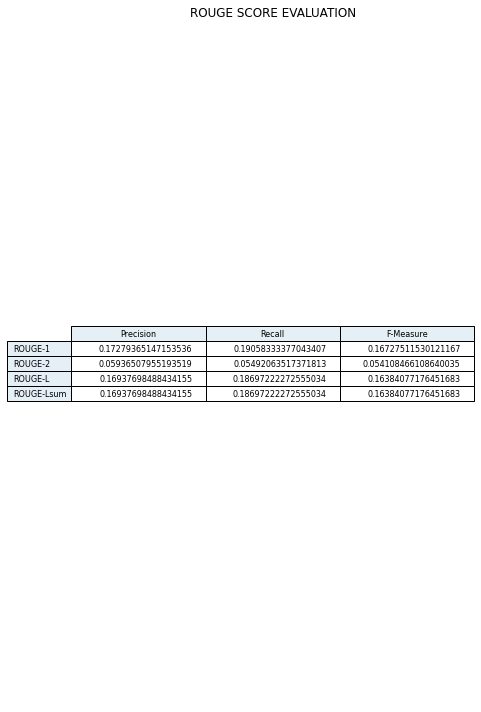

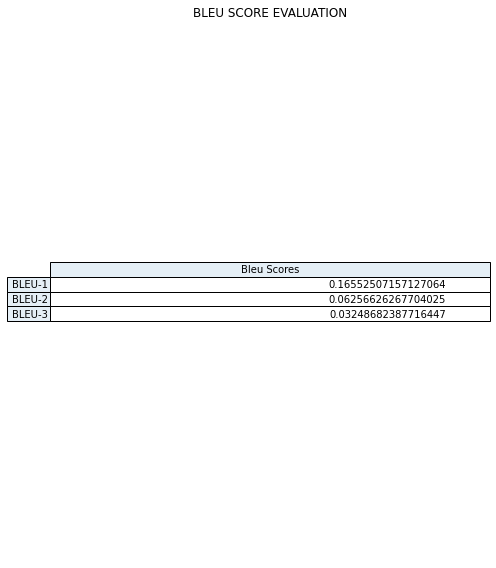

In [40]:
t5_folder = '../outputs/t5/'
from os import walk

f = []
for (dirpath, dirnames, csv_datafiles) in walk(t5_folder):
    for csv_file in csv_datafiles:
        present_metric_results("../outputs/t5/{}".format(csv_file))